In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from networkx.algorithms.isomorphism import GraphMatcher



In [2]:
df = pd.read_csv('PAHs.csv')
df['Mol'] = df['Smiles'].apply(Chem.MolFromSmiles)
df.rename(columns={'Smiles': 'SMILES'}, inplace=True)

In [3]:
df.head(2)

,SMILES,MP,Mol
0,c1ccc(-c2ccccc2)cc1,68.5,<rdkit.Chem.rdchem.Mol object at 0x000001E8554...
1,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,203.3,<rdkit.Chem.rdchem.Mol object at 0x000001E8554...


# Function definitions

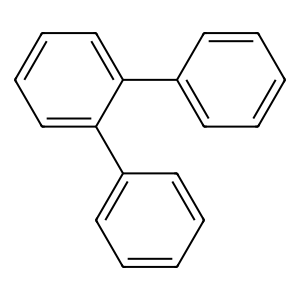

In [5]:
mol1 = df['Mol'][4]
# for atom in mol1.GetAtoms():
    # atom.SetProp("atomLabel", str(atom.GetIdx()))
Draw.MolToImage(mol1)

In [22]:
def get_benzene_rings(mol):
    rings = mol.GetRingInfo().AtomRings()
    benzene_rings = [set(ring) for ring in rings]
    return benzene_rings

In [23]:
get_benzene_rings(mol1)

[{0, 1, 2, 3, 16, 17}, {4, 5, 6, 7, 14, 15}, {8, 9, 10, 11, 12, 13}]

In [24]:
def build_ring_graph(mol):
    rings = get_benzene_rings(mol)  # list of sets of atom indices
    G = nx.Graph()

    # Add one node per ring
    for i in range(len(rings)):
        G.add_node(i)

    # Compare each ring pair
    for i in range(len(rings)):
        for j in range(i+1, len(rings)):
            shared = rings[i] & rings[j]
            
            if len(shared) == 2:
                G.add_edge(i, j, type='fused')  # Shared bond
            else:
                # Check for direct bond between atoms in the two rings
                for a1 in rings[i]:
                    for a2 in rings[j]:
                        if mol.GetBondBetweenAtoms(a1, a2):
                            G.add_edge(i, j, type='bond')  # Linked by external bond
                            break
    return G


In [25]:
def draw_ring_graph(G):
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=600)
    nx.draw_networkx_labels(G, pos)
    
    # Separate edges by type
    fused_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'fused']
    bond_edges  = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == 'bond']
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=fused_edges, edge_color='black', width=2, label='fused')
    nx.draw_networkx_edges(G, pos, edgelist=bond_edges, style='dashed', edge_color='red', width=2, label='bond')

    plt.show()

In [28]:
def draw_ring_graph_2(G):
    # Use a circular layout for more molecule-like appearance
    pos = nx.spring_layout(G, seed=42)  # can try nx.kamada_kawai_layout(G) or nx.shell_layout(G)

    # Define colors and styles
    node_color = '#A0CBE2'
    edge_colors = {'fused': 'black', 'bond': 'red'}
    edge_styles = {'fused': 'solid', 'bond': 'dashed'}

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=800, edgecolors='black', linewidths=1.5)

    # Draw labels (centered in each ring-node)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_family='sans-serif')

    # Draw edges by type
    for etype in ['fused', 'bond']:
        edgelist = [(u, v) for u, v, d in G.edges(data=True) if d['type'] == etype]
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=edgelist,
            style=edge_styles[etype],
            edge_color=edge_colors[etype],
            width=2
        )

    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [52]:
Chem.MolToSmiles(mol1)

'c1ccc(-c2cc(-c3ccccc3)cc(-c3c4ccccc4c(-c4c5ccccc5c(-c5cc(-c6ccccc6)cc(-c6ccccc6)c5)c5ccccc45)c4ccccc34)c2)cc1'

In [62]:
mol1 = df['Mol'][26]

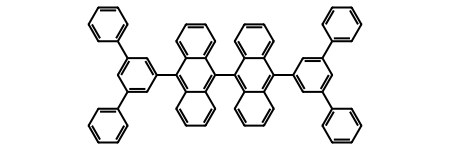

In [63]:
mol1

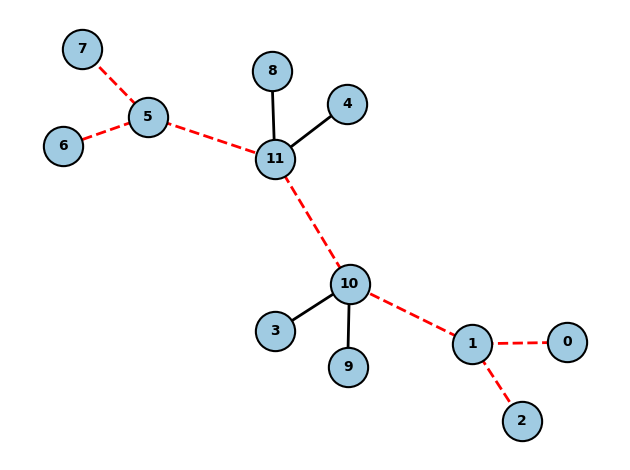

In [51]:
G = build_ring_graph(mol1)
draw_ring_graph_2(G)

# Data preprocessing

In [68]:
df['ring_graph'] = df['Mol'].apply(build_ring_graph)

In [69]:
def wiener_index(G):
    nodes = list(G.nodes)
    W = 0
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            W += nx.shortest_path_length(G, source=nodes[i], target=nodes[j])
    return W

In [70]:
def zagreb_index(G):
    return sum(G.degree(n)**2 for n in G.nodes)

In [71]:
df['W'] = df['ring_graph'].apply(wiener_index)
df['M1'] = df['ring_graph'].apply(zagreb_index)
df["num_rings"] = df["ring_graph"].apply(lambda G: G.number_of_nodes())


In [72]:
df.head()

,SMILES,MP,Mol,ring_graph,W,M1,num_rings
0,c1ccc(-c2ccccc2)cc1,68.5,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1)",1,2,2
1,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,203.3,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1, 2)",4,6,3
2,c1ccc(-c2cc(-c3ccccc3)cc(-c3c4ccccc4c(-c4cc(-c...,231.0,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",84,40,9
3,c1ccc(-c2cc(-c3ccccc3)cc(-c3ccccc3)c2)cc1,172.0,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1, 2, 3)",9,12,4
4,c1ccc(-c2ccccc2-c2ccccc2)cc1,59.0,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1, 2)",4,6,3


In [73]:
def plot_descriptor_vs_mp(df, descriptor_col):
    plt.figure(figsize=(6, 4))
    plt.scatter(df[descriptor_col], df["MP"], alpha=0.7)
    plt.xlabel(descriptor_col.replace('_', ' ').title())
    plt.ylabel("Melting Point")
    plt.title(f"Melting Point vs {descriptor_col.replace('_', ' ').title()}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

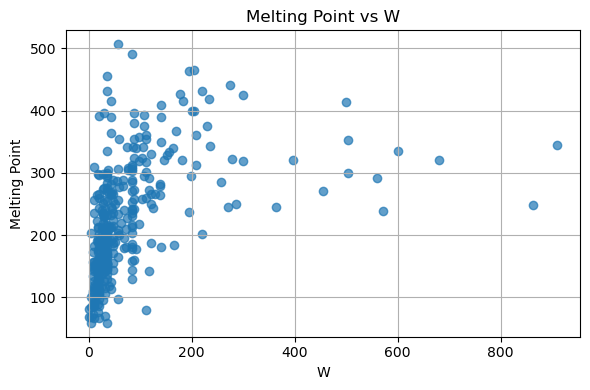

In [74]:
plot_descriptor_vs_mp(df, "W")

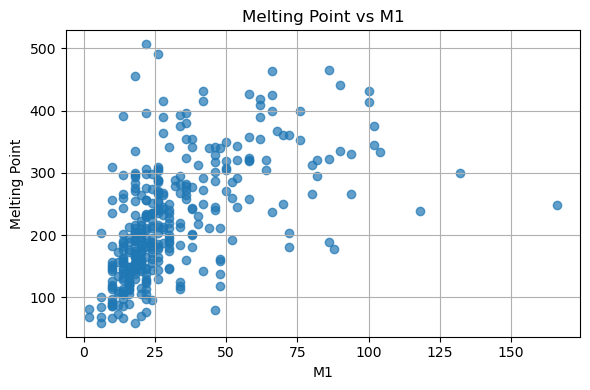

In [75]:
plot_descriptor_vs_mp(df, "M1")

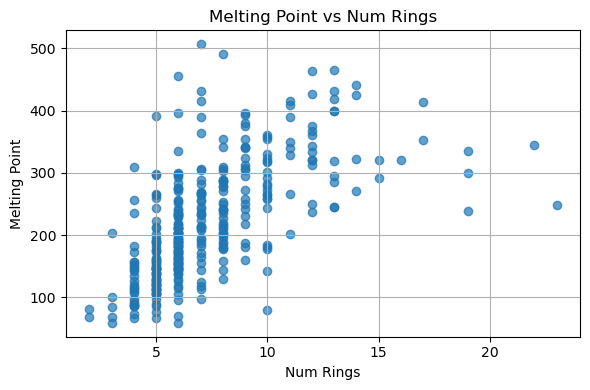

In [76]:
plot_descriptor_vs_mp(df, "num_rings")

In [77]:
def graph_to_mol(G):
    mol = Chem.RWMol()

    atom_map = {}
    for node in G.nodes:
        if G.degree[node] > 4:
            atom = Chem.Atom(0)  # Dummy atom
        else:
            atom = Chem.Atom(6)
        idx = mol.AddAtom(atom)
        atom_map[node] = idx

    for u, v in G.edges:
        mol.AddBond(atom_map[u], atom_map[v], Chem.BondType.SINGLE)

    mol = Chem.RWMol(mol)
    Chem.SanitizeMol(mol)
    return mol

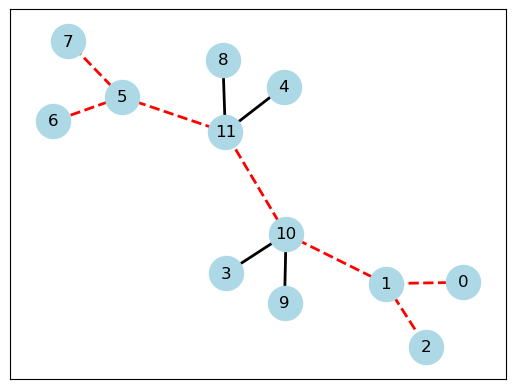

In [78]:
G = build_ring_graph(mol1)
draw_ring_graph(G)

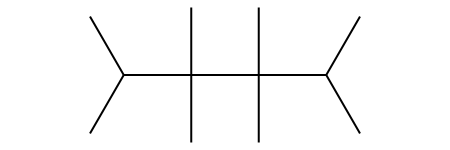

In [79]:
mol1 = graph_to_mol(G)
mol1

In [80]:
df['new_mol'] = df['ring_graph'].apply(graph_to_mol)

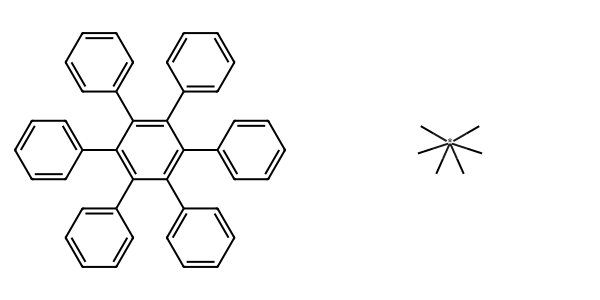

In [81]:
idx = 6

img = Draw.MolsToGridImage([df.iloc[idx]['Mol'], df.iloc[idx]['new_mol']], molsPerRow=2, subImgSize=(300, 300))
img

In [82]:
def simplify_graph(g):
    simplified_graph = nx.Graph()
    simplified_graph.add_nodes_from(g.nodes)
    simplified_graph.add_edges_from((u, v) for u, v, _ in g.edges(data=True))
    return simplified_graph

In [83]:
df['simplified_graph'] = df['ring_graph'].apply(simplify_graph)

In [98]:
# def are_isomorphic(graph1, graph2):
#     matcher = GraphMatcher(graph1, graph2)
#     return matcher.is_isomorphic()

def are_isomorphic(g1, g2):
    def edge_match(e1, e2):
        return e1.get('type') == e2.get('type')

    gm = GraphMatcher(g1, g2, edge_match=edge_match)
    return gm.is_isomorphic()

In [99]:
graph_identity = {}
group_id = 0

graph_ids = []
# for idx, g in df['simplified_graph'].items():
for idx, g in df['ring_graph'].items():
    found = False
    for prev_g, prev_id in graph_identity.items():
        if are_isomorphic(g, prev_g):
            graph_ids.append(prev_id)
            found = True
            break
    if not found:
        graph_identity[g] = group_id
        graph_ids.append(group_id)
        group_id += 1

df['graph_id'] = graph_ids

In [100]:
len(graph_identity)

174

In [87]:
df.head()

,SMILES,MP,Mol,ring_graph,W,M1,num_rings,new_mol,simplified_graph,graph_id
0,c1ccc(-c2ccccc2)cc1,68.5,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1)",1,2,2,<rdkit.Chem.rdchem.RWMol object at 0x0000018F2...,"(0, 1)",0
1,c1ccc(-c2ccc(-c3ccccc3)cc2)cc1,203.3,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1, 2)",4,6,3,<rdkit.Chem.rdchem.RWMol object at 0x0000018F2...,"(0, 1, 2)",1
2,c1ccc(-c2cc(-c3ccccc3)cc(-c3c4ccccc4c(-c4cc(-c...,231.0,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",84,40,9,<rdkit.Chem.rdchem.RWMol object at 0x0000018F2...,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",2
3,c1ccc(-c2cc(-c3ccccc3)cc(-c3ccccc3)c2)cc1,172.0,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1, 2, 3)",9,12,4,<rdkit.Chem.rdchem.RWMol object at 0x0000018F2...,"(0, 1, 2, 3)",3
4,c1ccc(-c2ccccc2-c2ccccc2)cc1,59.0,<rdkit.Chem.rdchem.Mol object at 0x0000018F1FC...,"(0, 1, 2)",4,6,3,<rdkit.Chem.rdchem.RWMol object at 0x0000018F2...,"(0, 1, 2)",1


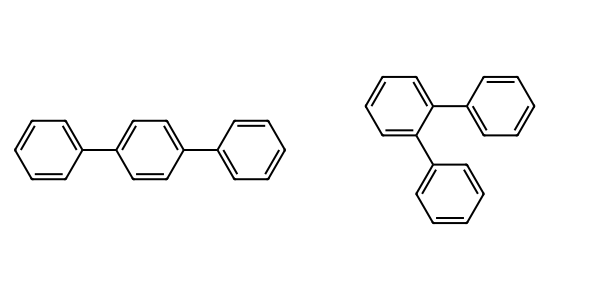

In [88]:
Draw.MolsToGridImage([df['Mol'][1], df['Mol'][4]], molsPerRow=2, subImgSize=(300, 300))

In [89]:
aggregated_df = df.groupby('graph_id').agg({
    'MP': ['mean', 'std', 'min', 'max'],
    'simplified_graph': 'first'
}).reset_index()

aggregated_df.columns = ['graph_id', 'MP_mean', 'MP_std', 'MP_min', 'MP_max', 'first_graph']

aggregated_df['MP_diff'] = aggregated_df['MP_max'] - aggregated_df['MP_min']

graph_indexes = df.reset_index().groupby('graph_id')['index'].apply(list).reset_index(drop=True)
aggregated_df['graph_indexes'] = graph_indexes

In [ ]:
aggregated_df[aggregated_df['MP_diff'] > 50]

,graph_id,MP_mean,MP_std,MP_min,MP_max,first_graph,MP_diff,graph_indexes
1,1,115.766667,76.912699,59.0,203.3,"(0, 1, 2)",144.3,"[1, 4, 5]"
3,3,146.533333,32.228300,110.3,172.0,"(0, 1, 2, 3)",61.7,"[3, 8, 9]"
5,5,149.666667,81.899980,88.6,309.5,"(0, 1, 2, 3)",220.9,"[7, 13, 16, 19, 21, 27]"
6,6,205.272727,80.925416,59.0,455.4,"(0, 1, 2, 3, 4, 5)",396.4,"[10, 31, 33, 36, 42, 45, 54, 55, 62, 69, 72, 7..."
7,7,225.700000,37.046457,190.7,264.5,"(0, 1, 2, 3, 4)",73.8,"[11, 12, 25]"
9,9,176.346667,76.373031,105.5,391.4,"(0, 1, 2, 3, 4)",285.9,"[15, 20, 32, 37, 39, 41, 44, 47, 57, 58, 59, 7..."
10,10,341.000000,104.651804,267.0,415.0,"(0, 1, 2, 3, 4, 5, 6)",148.0,"[17, 23]"
11,11,190.875000,41.578149,143.1,235.2,"(0, 1, 2, 3, 4, 5, 6)",92.1,"[18, 49, 94, 171]"
15,15,166.250000,65.690220,119.8,212.7,"(0, 1, 2, 3, 4)",92.9,"[28, 40]"
17,17,110.475000,32.467150,67.0,145.6,"(0, 1, 2, 3)",78.6,"[30, 38, 46, 48]"


In [93]:
aggregated_df.shape

(174, 8)

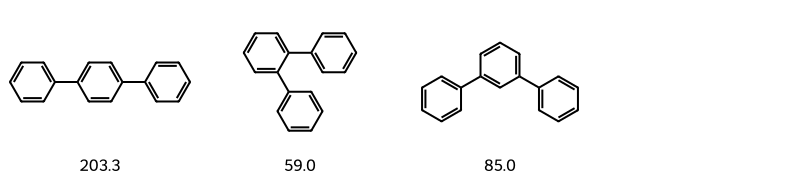

In [105]:
indexes = aggregated_df.loc[1, 'graph_indexes']

mols_to_display = df.loc[indexes, 'Mol'].tolist()
mp_values = df.loc[indexes, 'MP'].round(2).astype(str).tolist()  # Convert to string for display

Draw.MolsToGridImage(
    mols_to_display,
    molsPerRow=4,
    subImgSize=(200, 180),
    legends=mp_values
)

In [108]:
indexes = aggregated_df.loc[1, 'graph_indexes']

mols_to_display = df.loc[indexes, 'Mol'].tolist()
mp_values = df.loc[indexes, 'MP'].round(2).astype(str).tolist()  # Convert to string for display

# Generate SVG object
svg = Draw.MolsToGridImage(
    mols_to_display,
    molsPerRow=3,
    subImgSize=(200, 180),
    legends=mp_values,
    useSVG=True
)

# Convert SVG object to string
svg_str = svg.data

# Save SVG to file
with open("img/PAHs_MPs.svg", "w") as f:
    f.write(svg_str)